In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import re
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Load Data from PostgreSQL
db_config = {
    'host': 'localhost',
    'database': 'Liberty',
    'user': 'postgres',
    'password': 'abc',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

query = 'SELECT * FROM public.policydata_with_fb_cc_pc_newfea_opti_correct;'
data = pd.read_sql(query, con=engine)

selected_columns = ['rto_risk_factor', 'ncb % previous year', 'state_risk_score', 'retention_rate_pct', 'total od premium_max', 'applicable discount with ncb', 
                    'policy_wise_purchase', 'manufacturer_risk_rate', 'days_between_renewals', 'retention_streak', 'total od premium_mean', 'total od premium', 
                    'firstpolicyyear', 'lag_1_tp_premium', 'total od premium_min', 'avg_premium_hist', 'lag_1_ncb', 'age', 'total tp premium_max', 'total tp premium_mean', 
                    'total tp premium', 'total tp premium_min', 'lag_1_premium', 'previous_year_premium_ratio', 'total premium payable', 'total_revenue', 'gst', 
                    'fuel_type_risk_factor', 'lag_1_od_premium', 'Customer_APV', 'segment_risk_score', 'vehicle idv', 'Policy Tenure', 'Number of claims', 'approved', 
                    'claim_approval_rate', 'Customer Tenure', 'before gst add-on gwp', 'od_tp_ratio', 'add_on_adoption', 'CLV', 'idv_premium_ratio', 'Customer_APF', 
                    'days_gap_prev_end_to_curr_start', 'customerid', 'Claim Happaned/Not', 'Cleaned Branch Name 2', 'Cleaned Chassis Number', 'Cleaned Engine Number', 
                    'Cleaned Reg no', 'Cleaned State2', 'Cleaned Zone 2', 'biztype', 'corrected_name', 'make_clean', 'model_clean', 'product name', 'policy no', 
                    'policy end date', 'policy start date', 'decline', 'tie up', 'variant', 'Policy Status']

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('none')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['policy start date', 'policy end date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss, roc_curve
import matplotlib.pyplot as plt

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

Test Accuracy: 0.8503208550812866
Test Log Loss: 0.3593517267221092
Test ROC AUC: 0.923313377198989
Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81    111075
           1       0.91      0.85      0.88    189528

    accuracy                           0.85    300603
   macro avg       0.84      0.85      0.84    300603
weighted avg       0.86      0.85      0.85    300603

Class 0 Test Accuracy: 0.8481296421336935
Class 1 Test Accuracy: 0.8516050398885653
Train Accuracy: 0.8557076149899091
Train Log Loss: 0.34193078291661816
Train ROC AUC: 0.9292420136598775
Train Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85    758110
           1       0.85      0.86      0.86    758110

    accuracy                           0.86   1516220
   macro avg       0.86      0.86      0.86   1516220
weighted avg       0.86      0.86      0.86   1516220



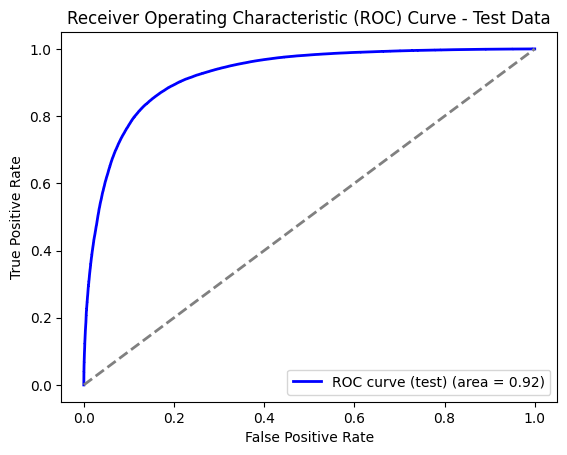

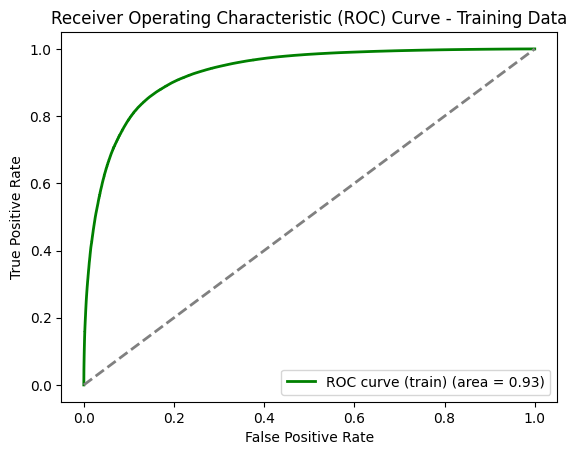

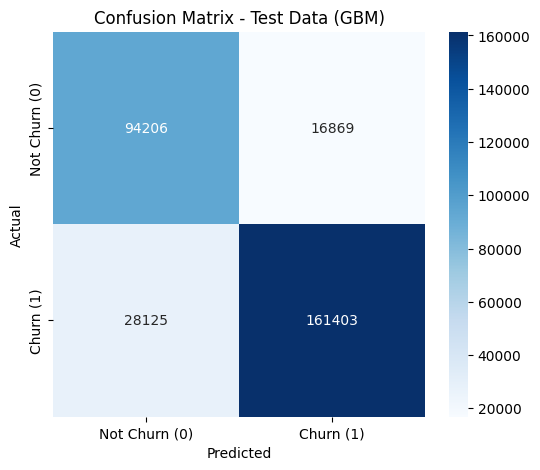

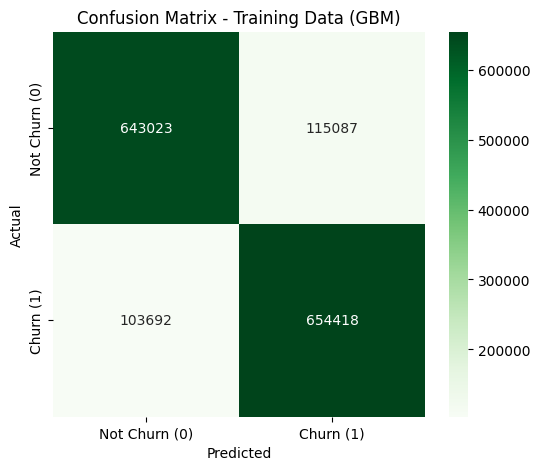


Confusion Matrix - Test Data (GBM):
[[ 94206  16869]
 [ 28125 161403]]

Confusion Matrix - Training Data (GBM):
[[643023 115087]
 [103692 654418]]


In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix - Test Data
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn (0)', 'Churn (1)'],
            yticklabels=['Not Churn (0)', 'Churn (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data (GBM)')
plt.show()

# Plot Confusion Matrix - Training Data
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Churn (0)', 'Churn (1)'],
            yticklabels=['Not Churn (0)', 'Churn (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data (GBM)')
plt.show()

print("\nConfusion Matrix - Test Data (GBM):")
print(conf_matrix_test)

print("\nConfusion Matrix - Training Data (GBM):")
print(conf_matrix_train)

Test Accuracy: 0.8503208550812866
Test Log Loss: 0.3593517267221092
Test ROC AUC: 0.923313377198989
Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81    111075
           1       0.91      0.85      0.88    189528

    accuracy                           0.85    300603
   macro avg       0.84      0.85      0.84    300603
weighted avg       0.86      0.85      0.85    300603

Class 0 Test Accuracy: 0.8481296421336935
Class 1 Test Accuracy: 0.8516050398885653
Train Accuracy: 0.8557076149899091
Train Log Loss: 0.34193078291661816
Train ROC AUC: 0.9292420136598775
Train Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85    758110
           1       0.85      0.86      0.86    758110

    accuracy                           0.86   1516220
   macro avg       0.86      0.86      0.86   1516220
weighted avg       0.86      0.86      0.86   1516220



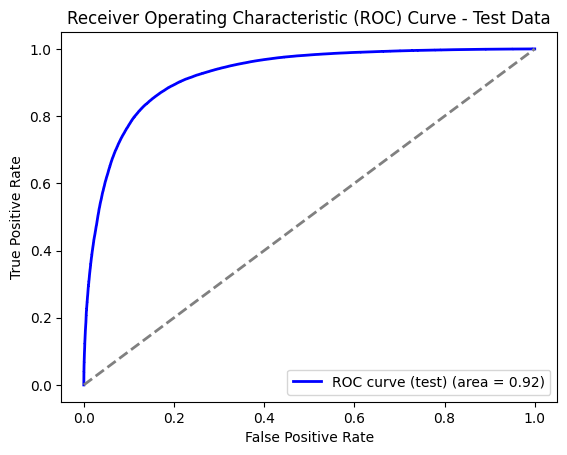

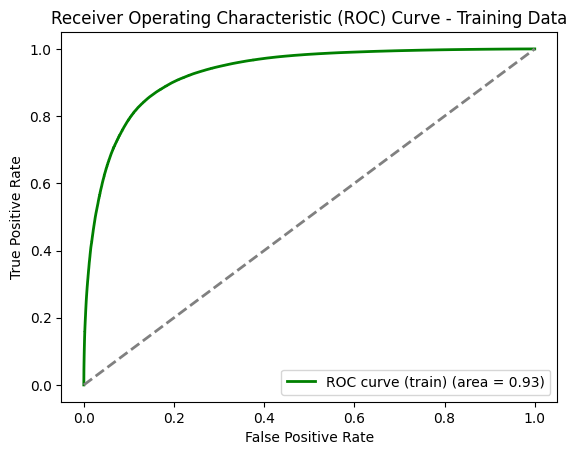

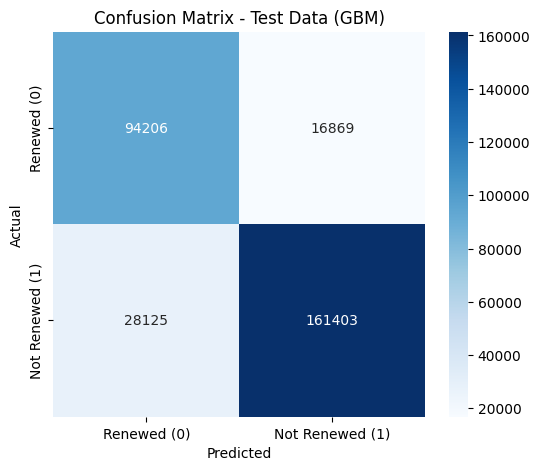

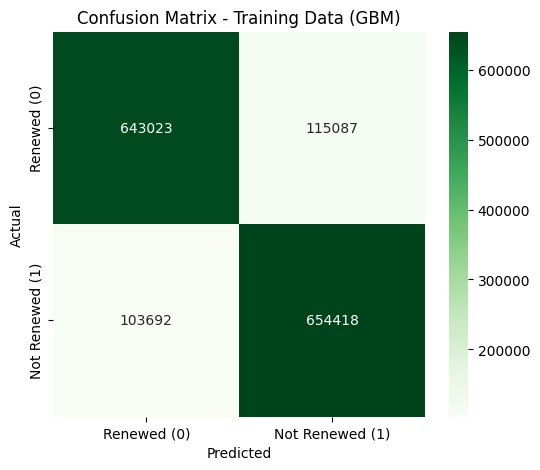


Confusion Matrix - Test Data (GBM):
[[ 94206  16869]
 [ 28125 161403]]

Confusion Matrix - Training Data (GBM):
[[643023 115087]
 [103692 654418]]


In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrix - Test Data
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Renewed (0)', 'Not Renewed (1)'],
            yticklabels=['Renewed (0)', 'Not Renewed (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Data (GBM)')
plt.show()

# Plot Confusion Matrix - Training Data
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Renewed (0)', 'Not Renewed (1)'],
            yticklabels=['Renewed (0)', 'Not Renewed (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data (GBM)')
plt.show()

print("\nConfusion Matrix - Test Data (GBM):")
print(conf_matrix_test)

print("\nConfusion Matrix - Training Data (GBM):")
print(conf_matrix_train)